# Survival impact of InstaPrism cell-type fractions (& Race) in Schildkraut HGSOC

This analysis investigates the prognostic impact of intratumoral cellular composition on survival outcomes in high-grade serous ovarian cancer (HGSOC). Using multivariable Cox proportional hazards models, we evaluate whether the abundance of adipocytes, stromal cells, immune cells, and epithelial cells within tumors is associated with overall mortality, separated by race (White and Black patients separately). Hazard ratios, confidence intervals, and p-values are reported for both complete-case and reduced-covariate models to assess robustness. The analysis further considers surgical variables such as bulky residual disease, allowing us to determine which tumor-intrinsic and clinical features independently predict patient survival.

**Results** 

Results stratified by race were similar (Supplemental Fig. 2 in paper). A 10% increase in adipocyte abundance was associated with a 42% higher hazard of death in Black patients (HR = 1.42, 95% CI 1.08-1.87, p = 0.011, n = 263) and a 43% higher hazard in White patients (HR = 1.43, 95% CI 1.11-1.84, p = 0.005, n = 303) after stratifying by stage and controlling for age and BMI.

In [1]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid, KFold
import os
from sklearn.preprocessing import StandardScaler
from matplotlib_venn import venn2
import sys

sys.path.insert(1, "../../")
sys.path.insert(1, "../")

import src.hp as hp

pd.set_option("display.max_rows", 100)
sns.set_style("ticks")

np.random.seed(88)

In [2]:
cell_types_to_use = [
    "Adipocytes"
]  # Adipocytes, Stromal, Immune, Epithelial. One per model.

complete_case = True

map_stage = True
remove_unknown_stage = True
remove_no_adj = False
remove_999_BMI = True
remove_BMI_treat = False

## Paths

In [3]:
base_path = os.path.dirname(os.getcwd())
meta_path = os.path.join(base_path, "input_data/metadata.xlsx")

In [4]:
if complete_case:
    remove_treatment = False
    remove_pts_with_unknowns = True
    title_for_plot = (
        f"{cell_types_to_use[0]} Int. with Race:\n Complete Case Model (n=268)"
    )

else:
    remove_treatment = True
    remove_pts_with_unknowns = False
    title_for_plot = (
        f"{cell_types_to_use[0]} Int. with Race:\n Reduced Covariate Model (n=566)"
    )

## Load InstaPrism cell-fraction tables (processed) and metadata

Proportions

In [5]:
props = pd.read_csv(
    os.path.join(base_path, "input_data/proportions_sch.csv"), index_col=0
)
props

,SampleID,Plasma cells,B cells,Endothelial cells,T cells,Monocytes,Fibroblasts,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset,suid,ID
0,18341X10,4.919765e-49,0.052767,0.029870,1.833554e-26,1.727071e-60,7.074672e-105,8.375315e-10,0.746341,1.257780e-139,3.590420e-30,2.867046e-78,1.185148e-02,1.538137e-57,0.0,0.159171,SchildkrautB,18341X10,45369
1,18341X12,9.351753e-92,0.027159,0.011666,5.972580e-66,2.258210e-157,8.180384e-107,8.135649e-61,0.848153,3.276474e-210,2.054386e-103,1.247009e-85,2.337775e-128,1.452291e-115,0.0,0.113022,SchildkrautB,18341X12,47261
2,18341X13,6.998799e-32,0.014663,0.041547,1.004614e-23,3.232466e-34,1.225464e-02,9.550579e-19,0.819028,1.104356e-115,3.157063e-69,7.123720e-41,2.994756e-02,1.850941e-63,0.0,0.082561,SchildkrautB,18341X13,47791
3,18341X14,2.410384e-97,0.162711,0.022343,2.056824e-52,5.485488e-33,2.751866e-120,7.904174e-39,0.642545,4.774011e-154,1.326676e-75,2.334007e-77,1.516542e-02,1.488048e-80,0.0,0.157235,SchildkrautB,18341X14,47916
4,18341X15,3.439318e-76,0.050581,0.055021,5.687981e-28,5.314872e-52,8.961526e-02,2.919113e-22,0.649017,7.625379e-122,1.873123e-52,3.487465e-81,1.419715e-02,4.216693e-41,0.0,0.141568,SchildkrautB,18341X15,48002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,20160X95,1.442627e-108,0.136578,0.014420,3.410104e-30,3.267116e-82,7.666630e-23,1.501224e-35,0.710289,6.509988e-151,4.903142e-78,8.571710e-105,3.473745e-03,5.671299e-79,0.0,0.135240,SchildkrautW,20160X95,47786
584,20160X96,1.359916e-92,0.190881,0.017396,5.383974e-33,2.734703e-86,1.156925e-02,1.945285e-24,0.592805,1.063562e-147,5.374615e-82,8.551669e-96,1.270617e-02,4.370517e-04,0.0,0.174205,SchildkrautW,20160X96,47903
585,20160X97,7.862780e-79,0.102850,0.053137,8.610293e-03,1.076987e-46,4.237821e-02,1.467756e-05,0.656171,3.397744e-114,5.089409e-39,1.625064e-79,2.253584e-02,9.865474e-05,0.0,0.114204,SchildkrautW,20160X97,47926
586,20160X98,1.245316e-60,0.127050,0.034344,1.345753e-16,5.846372e-04,2.787547e-02,2.169830e-04,0.673204,4.422809e-95,4.998254e-48,3.881728e-35,5.796692e-04,4.236351e-47,0.0,0.136146,SchildkrautW,20160X98,47937


In [6]:
# Define the desired order for the plots based on settings
if remove_BMI_treat:
    desired_order = [
        "Age",
        "No Adj Tx.",
        "Race: Black",
        "Race: Black x Adipocytes",
        "Residual: < 1cm",
        "Residual: ≥ 1cm",
        "Residual: Unknown size",
    ]
else:
    desired_order = [
        "Age",
        "BMI",
        "No Adj Tx.",
        "Race: Black",
        "Race: Black x Adipocytes",
        "Residual: < 1cm",
        "Residual: ≥ 1cm",
        "Residual: Unknown size",
    ]

# If treatment is removed, exclude treatment-related variables
if remove_treatment:
    for col in [
        "No Adj Tx.",
        "Residual: < 1cm",
        "Residual: ≥ 1cm",
        "Residual: Unknown size",
    ]:
        desired_order.remove(col)

desired_order

['Age',
 'BMI',
 'No Adj Tx.',
 'Race: Black',
 'Race: Black x Adipocytes',
 'Residual: < 1cm',
 'Residual: ≥ 1cm',
 'Residual: Unknown size']

In [7]:
groups = {
    "Immune": [
        "B cells",
        "Mast cells",
        "T cells",
        "Monocytes",
        "Plasma cells",
        "NK cells",
        "DC",
        "pDC",
        "Macrophages",
        "ILC",
    ],
    "Stromal": ["Fibroblasts", "Endothelial cells"],
    "Adipocytes": ["Adipocytes"],
    "Epithelial": ["Epithelial cells"],
}
key = cell_types_to_use[0]
desired_order.append(key)
props[key] = props[groups[key]].sum(axis=1) * 10
props

,SampleID,Plasma cells,B cells,Endothelial cells,T cells,Monocytes,Fibroblasts,NK cells,Epithelial cells,DC,pDC,ILC,Macrophages,Mast cells,Erythroid,Adipocytes,Dataset,suid,ID
0,18341X10,4.919765e-49,0.052767,0.029870,1.833554e-26,1.727071e-60,7.074672e-105,8.375315e-10,0.746341,1.257780e-139,3.590420e-30,2.867046e-78,1.185148e-02,1.538137e-57,0.0,1.591710,SchildkrautB,18341X10,45369
1,18341X12,9.351753e-92,0.027159,0.011666,5.972580e-66,2.258210e-157,8.180384e-107,8.135649e-61,0.848153,3.276474e-210,2.054386e-103,1.247009e-85,2.337775e-128,1.452291e-115,0.0,1.130216,SchildkrautB,18341X12,47261
2,18341X13,6.998799e-32,0.014663,0.041547,1.004614e-23,3.232466e-34,1.225464e-02,9.550579e-19,0.819028,1.104356e-115,3.157063e-69,7.123720e-41,2.994756e-02,1.850941e-63,0.0,0.825608,SchildkrautB,18341X13,47791
3,18341X14,2.410384e-97,0.162711,0.022343,2.056824e-52,5.485488e-33,2.751866e-120,7.904174e-39,0.642545,4.774011e-154,1.326676e-75,2.334007e-77,1.516542e-02,1.488048e-80,0.0,1.572353,SchildkrautB,18341X14,47916
4,18341X15,3.439318e-76,0.050581,0.055021,5.687981e-28,5.314872e-52,8.961526e-02,2.919113e-22,0.649017,7.625379e-122,1.873123e-52,3.487465e-81,1.419715e-02,4.216693e-41,0.0,1.415675,SchildkrautB,18341X15,48002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,20160X95,1.442627e-108,0.136578,0.014420,3.410104e-30,3.267116e-82,7.666630e-23,1.501224e-35,0.710289,6.509988e-151,4.903142e-78,8.571710e-105,3.473745e-03,5.671299e-79,0.0,1.352398,SchildkrautW,20160X95,47786
584,20160X96,1.359916e-92,0.190881,0.017396,5.383974e-33,2.734703e-86,1.156925e-02,1.945285e-24,0.592805,1.063562e-147,5.374615e-82,8.551669e-96,1.270617e-02,4.370517e-04,0.0,1.742051,SchildkrautW,20160X96,47903
585,20160X97,7.862780e-79,0.102850,0.053137,8.610293e-03,1.076987e-46,4.237821e-02,1.467756e-05,0.656171,3.397744e-114,5.089409e-39,1.625064e-79,2.253584e-02,9.865474e-05,0.0,1.142044,SchildkrautW,20160X97,47926
586,20160X98,1.245316e-60,0.127050,0.034344,1.345753e-16,5.846372e-04,2.787547e-02,2.169830e-04,0.673204,4.422809e-95,4.998254e-48,3.881728e-35,5.796692e-04,4.236351e-47,0.0,1.361460,SchildkrautW,20160X98,47937


In [8]:
# ─────────────────────────────────────────────────────────────────────────
#  We'll scale the proportions to improve convergence of the Cox model.
#  This is not strictly necessary, but it can help with numerical stability.
# ─────────────────────────────────────────────────────────────────────────
keep_cols = cell_types_to_use + ["SampleID", "Dataset", "ID"]
props = props[keep_cols]

## Merge, encode categorical covariates

### Build the analysis table  (clinical + cell fractions)


In [9]:
renaming = hp.get_variable_renaming()
tissue_dictionary = hp.get_tissue_dictionary()

Metadata

In [10]:
## Importing and renaming metadata
# continuous covariates to keep “as is”
if remove_BMI_treat:
    cont_cols = ["Age"]
else:
    cont_cols = ["Age", "BMI"]

# ------------------------------ clinical columns -----------------
meta_full = (
    pd.read_excel(meta_path, sheet_name=0)
    .rename(columns=str.strip)
    .rename(columns=renaming)
)

meta_full = meta_full[renaming.values()]

meta_full["Stage"] = pd.to_numeric(meta_full["Stage"], errors="coerce")

meta_full["Event"] = meta_full["Event"].astype(int)
meta_full["Time-Days"] = meta_full["Time_Yrs"] * 365.22

meta_full

,ID,Age,Event,Time_Yrs,Tissue,Stage,Race,Debulk,Hispanic,BMI,NeoTx,AdjTx,Residual,Time-Days
0,40143,63,1,8.739220,NaN,3,1,2.0,2,23.218229,2.0,1.0,4.0,3191.737824
1,41377,54,1,1.180014,NaN,3,1,2.0,2,17.428942,2.0,NaN,3.0,430.964599
2,41387,55,1,11.983573,NaN,3,2,1.0,2,45.470350,2.0,1.0,2.0,4376.640495
3,41391,60,1,4.993840,NaN,3,1,2.0,2,31.340800,2.0,NaN,3.0,1823.850185
4,41435,59,1,4.057495,NaN,3,1,NaN,2,23.922658,NaN,NaN,NaN,1481.878275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0,9.702186,right fallopian tube,3,2,NaN,2,28.349557,NaN,NaN,NaN,3543.432295
584,320012,66,0,11.767760,NaN,3,2,2.0,2,37.677475,2.0,1.0,4.0,4297.821147
585,320025,60,1,6.827869,omentum or ovary,3,2,2.0,2,38.740537,2.0,1.0,3.0,2493.674262
586,320043,57,1,1.553425,NaN,3,2,2.0,2,19.854802,2.0,1.0,4.0,567.341754


In [11]:
meta_full[meta_full.BMI > 998].shape  ## Thirteen patients have BMI == 999

(13, 14)

Cross-tabulation of Debulk vs Residual:
Residual  1.0  2.0  3.0  4.0
Debulk                      
1.0       110   99    0    0
2.0         0    0   39   52


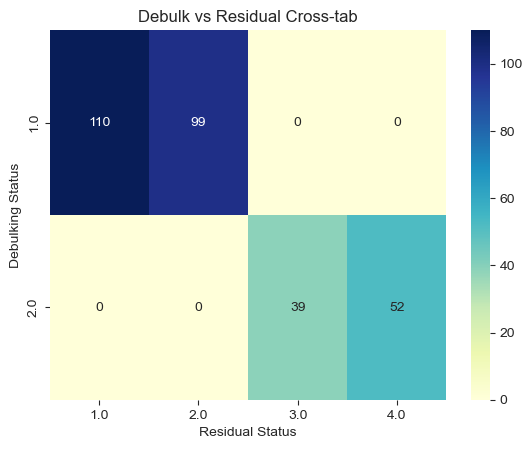

In [12]:
# cross-tabulation to examine relationship
cross_tab = pd.crosstab(meta_full["Debulk"], meta_full["Residual"])
print("Cross-tabulation of Debulk vs Residual:")
print(cross_tab)

# visualize the cross-tab for better pattern recognition
sns.heatmap(cross_tab, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Debulk vs Residual Cross-tab")
plt.xlabel("Residual Status")
plt.ylabel("Debulking Status")
plt.show()

Filtering samples

In [13]:
meta_full.Hispanic.value_counts(dropna=False)

Hispanic
2     583
1       3
99      2
Name: count, dtype: int64

In [14]:
if remove_unknown_stage:
    first = meta_full.shape[0]
    meta_full = meta_full[meta_full["Stage"] != 9]
    print("Removed for unknown stage: ", first - meta_full.shape[0])

if remove_999_BMI:
    first = meta_full.shape[0]
    meta_full = meta_full[meta_full["BMI"] != 999]
    print("Removed for BMI 999: ", first - meta_full.shape[0])

# In no case we'd use Hispanic variable:
meta_full.drop(columns=["Hispanic"], inplace=True)

# We are removing debulking treatment that includes CA125.
meta_full.drop(columns=["Debulk"], inplace=True)

meta_full.drop(columns=["NeoTx"], inplace=True)

meta_full.drop(columns=["Tissue"], inplace=True)

meta_full

Removed for unknown stage:  9
Removed for BMI 999:  13


,ID,Age,Event,Time_Yrs,Stage,Race,BMI,AdjTx,Residual,Time-Days
0,40143,63,1,8.739220,3,1,23.218229,1.0,4.0,3191.737824
1,41377,54,1,1.180014,3,1,17.428942,NaN,3.0,430.964599
2,41387,55,1,11.983573,3,2,45.470350,1.0,2.0,4376.640495
3,41391,60,1,4.993840,3,1,31.340800,NaN,3.0,1823.850185
4,41435,59,1,4.057495,3,1,23.922658,NaN,NaN,1481.878275
...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0,9.702186,3,2,28.349557,NaN,NaN,3543.432295
584,320012,66,0,11.767760,3,2,37.677475,1.0,4.0,4297.821147
585,320025,60,1,6.827869,3,2,38.740537,1.0,3.0,2493.674262
586,320043,57,1,1.553425,3,2,19.854802,1.0,4.0,567.341754


In [15]:
# If we remove treatment we only keep Race and Stage of the categoricals.
if remove_treatment:
    cat_cols = ["Stage", "Race"]
    meta_full[cat_cols] = meta_full[cat_cols].astype("category")
    meta_full.columns
else:
    cat_cols = ["Stage", "Race", "Residual", "AdjTx"]
    meta_full[cat_cols] = meta_full[cat_cols].astype("category")
    meta_full.columns


if remove_BMI_treat:
    meta_full.drop(columns=["BMI"], inplace=True)

meta_full

,ID,Age,Event,Time_Yrs,Stage,Race,BMI,AdjTx,Residual,Time-Days
0,40143,63,1,8.739220,3,1,23.218229,1.0,4.0,3191.737824
1,41377,54,1,1.180014,3,1,17.428942,NaN,3.0,430.964599
2,41387,55,1,11.983573,3,2,45.470350,1.0,2.0,4376.640495
3,41391,60,1,4.993840,3,1,31.340800,NaN,3.0,1823.850185
4,41435,59,1,4.057495,3,1,23.922658,NaN,NaN,1481.878275
...,...,...,...,...,...,...,...,...,...,...
583,310266,40,0,9.702186,3,2,28.349557,NaN,NaN,3543.432295
584,320012,66,0,11.767760,3,2,37.677475,1.0,4.0,4297.821147
585,320025,60,1,6.827869,3,2,38.740537,1.0,3.0,2493.674262
586,320043,57,1,1.553425,3,2,19.854802,1.0,4.0,567.341754


In [16]:
# ------------------------------ merge meta + props ----------------------------
# every SampleID maps to a unique suid)
analysis = props.merge(meta_full, on="ID", how="inner")

print(f"Using: {analysis.shape[0]} rows, {analysis['ID'].nunique()} patients")

analysis

Using: 566 rows, 566 patients


,Adipocytes,SampleID,Dataset,ID,Age,Event,Time_Yrs,Stage,Race,BMI,AdjTx,Residual,Time-Days
0,1.591710,18341X10,SchildkrautB,45369,53,1,2.004107,3,2,31.110562,1.0,3.0,731.939877
1,1.130216,18341X12,SchildkrautB,47261,57,1,5.240246,3,2,29.448927,NaN,NaN,1913.842793
2,0.825608,18341X13,SchildkrautB,47791,45,1,4.396988,3,2,40.981420,NaN,NaN,1605.868090
3,1.572353,18341X14,SchildkrautB,47916,68,1,2.151951,4,2,28.928061,NaN,NaN,785.935442
4,1.415675,18341X15,SchildkrautB,48002,44,1,1.508556,3,2,24.991295,1.0,2.0,550.954743
...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,1.352398,20160X95,SchildkrautW,47786,68,1,2.554415,3,1,31.538819,NaN,NaN,932.923367
562,1.742051,20160X96,SchildkrautW,47903,45,1,2.910335,3,1,20.410354,NaN,NaN,1062.912690
563,1.142044,20160X97,SchildkrautW,47926,52,0,14.414784,3,1,34.458370,NaN,NaN,5264.567555
564,1.361460,20160X98,SchildkrautW,47937,43,1,3.238877,3,1,20.156950,1.0,2.0,1182.902834


In [17]:
## Mapping the stage variable for stratification
if map_stage:
    stage_map = {1: 1, 2: 1, 3: 2, 4: 2}
    analysis["Stage"] = analysis.Stage.map(stage_map)

if remove_pts_with_unknowns:
    print("Going from: ", analysis.shape)
    analysis = analysis.dropna(subset=["Residual", "AdjTx"])
    print("To: ", analysis.shape)

analysis

Going from:  (566, 13)
To:  (268, 13)


,Adipocytes,SampleID,Dataset,ID,Age,Event,Time_Yrs,Stage,Race,BMI,AdjTx,Residual,Time-Days
0,1.591710,18341X10,SchildkrautB,45369,53,1,2.004107,2,2,31.110562,1.0,3.0,731.939877
4,1.415675,18341X15,SchildkrautB,48002,44,1,1.508556,2,2,24.991295,1.0,2.0,550.954743
9,2.161446,18341X27,SchildkrautB,46196,67,1,4.635181,2,2,32.198190,1.0,2.0,1692.860945
17,1.816324,18341X35,SchildkrautB,47251,71,1,1.234771,2,2,23.620798,1.0,2.0,450.962957
18,1.298331,18341X38,SchildkrautB,47927,51,1,2.570842,2,2,21.873770,1.0,2.0,938.922875
...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,1.334981,20160X90,SchildkrautW,47148,47,1,1.984942,2,1,39.153028,1.0,3.0,724.940452
557,1.665924,20160X91,SchildkrautW,47185,57,1,11.512663,2,1,43.240248,1.0,2.0,4204.654620
558,1.098901,20160X92,SchildkrautW,47226,71,1,5.577002,2,1,20.892489,1.0,2.0,2036.832690
564,1.361460,20160X98,SchildkrautW,47937,43,1,3.238877,2,1,20.156950,1.0,2.0,1182.902834


In [18]:
for col in analysis:
    print(analysis[col].value_counts(dropna=False))

Adipocytes
1.591710    1
1.438614    1
0.900286    1
1.202717    1
1.174888    1
           ..
1.562868    1
1.300464    1
2.078855    1
3.047693    1
1.484585    1
Name: count, Length: 268, dtype: int64
SampleID
18341X10     1
20160X131    1
20160X115    1
20160X117    1
20160X118    1
            ..
19291X25     1
19291X251    1
19291X252    1
19291X254    1
20160X99     1
Name: count, Length: 268, dtype: int64
Dataset
SchildkrautB    157
SchildkrautW    111
Name: count, dtype: int64
ID
45369     1
48066     1
47209     1
47249     1
47442     1
         ..
43592     1
190009    1
190010    1
190032    1
47991     1
Name: count, Length: 268, dtype: int64
Age
63    13
57    12
61    12
52    11
54    10
67    10
71    10
62    10
56    10
58     9
53     9
55     9
51     9
60     8
72     8
49     7
68     7
73     7
43     7
50     7
66     6
70     6
65     6
69     6
64     6
59     6
46     5
48     5
44     5
45     5
47     5
42     4
74     4
39     3
77     3
41     2
76     

In [19]:
if remove_treatment:
    if remove_BMI_treat:
        cols = ["Age", "Event", "Time_Yrs", "Time-Days", "Stage", "Residual", "AdjTx"]
    else:
        cols = [
            "Age",
            "Event",
            "Time_Yrs",
            "BMI",
            "Time-Days",
            "Stage",
            "Residual",
            "AdjTx",
        ]

    cat_cols = ["Race"]
    # Get dummys for categorical columns with more than 2 cats (NaN counts as category)
    dummies = pd.get_dummies(
        analysis, columns=cat_cols, drop_first=True, prefix_sep="_"
    )
    dummies.drop(columns=props.columns, inplace=True)  # remove original proportions
    dummies.drop(columns=cols, inplace=True)  # remove original proportions
    dummies

else:
    if remove_BMI_treat:
        cols = ["Age", "Event", "Time_Yrs", "Time-Days", "Stage"]
    else:
        cols = ["Age", "Event", "Time_Yrs", "BMI", "Time-Days", "Stage"]

    cat_cols = ["Residual", "AdjTx", "Race"]
    # Get dummys for categorical columns with more than 2 cats (NaN counts as category)
    dummies = pd.get_dummies(
        analysis, columns=cat_cols, drop_first=True, prefix_sep="_"
    )
    dummies.drop(columns=props.columns, inplace=True)  # remove original proportions
    dummies.drop(columns=cols, inplace=True)  # remove original proportions
dummies

,Residual_2.0,Residual_3.0,Residual_4.0,AdjTx_2.0,Race_2
0,False,True,False,False,True
4,True,False,False,False,True
9,True,False,False,False,True
17,True,False,False,False,True
18,True,False,False,False,True
...,...,...,...,...,...
556,False,True,False,False,False
557,True,False,False,False,False
558,True,False,False,False,False
564,True,False,False,False,False


In [20]:
for col in dummies:
    print(dummies[col].value_counts(dropna=False))

Residual_2.0
False    177
True      91
Name: count, dtype: int64
Residual_3.0
False    235
True      33
Name: count, dtype: int64
Residual_4.0
False    223
True      45
Name: count, dtype: int64
AdjTx_2.0
False    262
True       6
Name: count, dtype: int64
Race_2
True     157
False    111
Name: count, dtype: int64


In [21]:
# Put together the analysis DataFrame
# (keep the original categorical columns for later use)
analysis_enc = pd.concat([analysis, dummies], axis=1)  # Columns that go into the model
cell_cols = props.columns.difference(["SampleID", "Dataset", "ID"])  # fractions
covars = cont_cols + list(dummies.columns) + list(cell_cols) + ["Stage"]

covars

['Age',
 'BMI',
 'Residual_2.0',
 'Residual_3.0',
 'Residual_4.0',
 'AdjTx_2.0',
 'Race_2',
 'Adipocytes',
 'Stage']

In [22]:
cox_df = analysis_enc[["Time-Days", "Event"] + covars].copy()

# and let's make names more interpretable:
if "AdjTx_2.0" in cox_df.columns:
    cox_df.rename(columns={"AdjTx_2.0": "No Adj Tx."}, inplace=True)
if "Race_2" in cox_df.columns:
    cox_df.rename(columns={"Race_2": "Race: Black"}, inplace=True)
if "Residual_4.0" in cox_df.columns:
    cox_df.rename(columns={"Residual_4.0": "Residual: Unknown size"}, inplace=True)
    cox_df.rename(columns={"Residual_3.0": "Residual: ≥ 1cm"}, inplace=True)
    cox_df.rename(columns={"Residual_2.0": "Residual: < 1cm"}, inplace=True)

In [23]:
print("Design matrix:", cox_df.shape)
print("Design matrix columns:", cox_df.columns)
cox_df

Design matrix: (268, 11)
Design matrix columns: Index(['Time-Days', 'Event', 'Age', 'BMI', 'Residual: < 1cm',
       'Residual: ≥ 1cm', 'Residual: Unknown size', 'No Adj Tx.',
       'Race: Black', 'Adipocytes', 'Stage'],
      dtype='object')


,Time-Days,Event,Age,BMI,Residual: < 1cm,Residual: ≥ 1cm,Residual: Unknown size,No Adj Tx.,Race: Black,Adipocytes,Stage
0,731.939877,1,53,31.110562,False,True,False,False,True,1.591710,2
4,550.954743,1,44,24.991295,True,False,False,False,True,1.415675,2
9,1692.860945,1,67,32.198190,True,False,False,False,True,2.161446,2
17,450.962957,1,71,23.620798,True,False,False,False,True,1.816324,2
18,938.922875,1,51,21.873770,True,False,False,False,True,1.298331,2
...,...,...,...,...,...,...,...,...,...,...,...
556,724.940452,1,47,39.153028,False,True,False,False,False,1.334981,2
557,4204.654620,1,57,43.240248,True,False,False,False,False,1.665924,2
558,2036.832690,1,71,20.892489,True,False,False,False,False,1.098901,2
564,1182.902834,1,43,20.156950,True,False,False,False,False,1.361460,2


### K-fold for model penalizer

Uses 5-fold cross-validation to evaluate model performance, using concordance index (a standard survival metric).

In [24]:
# Note that this tuning does not have the race interaction term (fails assumptions anyway)
cv_table, best, fails = hp.tune_cox_penalty(
    cox_df, duration_col="Time-Days", event_col="Event", strata="Stage", k=5  # or None
)

print("Best hyper-parameters:")
print(best)

print("\nTop 5 grid points:")
display(cv_table.head())

if not fails.empty:
    print("\nFailures:")
    display(fails)

/Users/ivicha/anaconda3/envs/env_deconv/lib/python3.10/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
/Users/ivicha/anaconda3/envs/env_deconv/lib/python3.10/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
/Users/ivicha/anaconda3/envs/env_deconv/lib/python3.10/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
/Users/ivicha/anaconda3/envs/env_deconv/lib/python3.10/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to 

Best hyper-parameters:
{'l1_ratio': 0.0, 'penalizer': 0.0001, 'c_index_mean': 0.6090963315197924, 'c_index_sd': 0.03959546258262208}

Top 5 grid points:


/Users/ivicha/anaconda3/envs/env_deconv/lib/python3.10/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
/Users/ivicha/anaconda3/envs/env_deconv/lib/python3.10/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
/Users/ivicha/anaconda3/envs/env_deconv/lib/python3.10/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to incrementing index instead.
  warnings.warn("DataFrame Index is not unique, defaulting to incrementing index instead.")
/Users/ivicha/anaconda3/envs/env_deconv/lib/python3.10/site-packages/lifelines/utils/__init__.py:933: UserWarning: DataFrame Index is not unique, defaulting to 

,l1_ratio,penalizer,c_index_mean,c_index_sd
0,0.0,0.0001,0.609096,0.039595
2,0.0,0.0100,0.609033,0.035608
3,0.0,0.0500,0.598201,0.030836
5,0.0,0.2000,0.598188,0.040411
4,0.0,0.1000,0.596779,0.012847


In [25]:
# we'll rename for easeness
cph = CoxPHFitter(l1_ratio=best["l1_ratio"], penalizer=best["penalizer"])

if complete_case:
    cox_df = cox_df.rename(
        columns={
            "Race: Black": "Race_Black",
            "Residual: < 1cm": "Resless1cm",
            "Residual: ≥ 1cm": "Resmore1cm",
            "Residual: Unknown size": "ResUnkownSize",
            "No Adj Tx.": "NoAdjTx",
        }
    )
    cph.fit(
        cox_df,
        duration_col="Time-Days",
        event_col="Event",
        strata=["Stage"],
        formula="Age + BMI +  Resless1cm + Resmore1cm + ResUnkownSize + NoAdjTx + Race_Black * Adipocytes",
        show_progress=True,
    )
    desired_order = [
        "Age",
        "BMI",
        "Residual: < 1cm",
        "Residual: ≥ 1cm",
        "Residual: Unknown size",
        "No Adj Tx.",
        "Race: Black",
        "Adipocytes",
        "Race: Black x Adipocytes",
    ]
else:
    cox_df = cox_df.rename(columns={"Race: Black": "Race_Black"})
    cph.fit(
        cox_df,
        duration_col="Time-Days",
        event_col="Event",
        strata=["Stage"],
        formula="BMI + Age + Race_Black * Adipocytes",
        show_progress=True,
    )
    desired_order = [
        "Age",
        "BMI",
        "Race: Black",
        "Adipocytes",
        "Race: Black x Adipocytes",
    ]
cph.print_summary(columns=["coef", "exp(coef)", "p", "z"])

cph.summary

Iteration 1: norm_delta = 4.96e-01, step_size = 0.9500, log_lik = -953.52570, newton_decrement = 1.64e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 6.38e-02, step_size = 0.9500, log_lik = -938.43508, newton_decrement = 2.60e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 3.45e-03, step_size = 0.9500, log_lik = -938.17671, newton_decrement = 5.45e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 4.21e-06, step_size = 1.0000, log_lik = -938.17616, newton_decrement = 6.36e-10, seconds_since_start = 0.0
Convergence success after 4 iterations.


model,lifelines.CoxPHFitter
duration col,'Time-Days'
event col,'Event'
penalizer,0.0001
l1 ratio,0.0
strata,Stage
baseline estimation,breslow
number of observations,268
number of events observed,206
partial log-likelihood,-938.18
time fit was run,2025-08-19 21:57:31 UTC


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Age,0.003939,1.003947,0.007758,-0.011267,0.019145,0.988796,1.019329,0.0,0.507726,0.611645,0.709233
BMI,0.001788,1.001789,0.009784,-0.017389,0.020964,0.982762,1.021185,0.0,0.182720,0.855018,0.225973
Resless1cm,0.336063,1.399427,0.183533,-0.023655,0.695781,0.976622,2.005275,0.0,1.831076,0.067089,3.897774
Resmore1cm,0.867121,2.380050,0.231319,0.413744,1.320499,1.512470,3.745289,0.0,3.748592,0.000178,12.457213
ResUnkownSize,0.787885,2.198740,0.215213,0.366075,1.209694,1.442063,3.352460,0.0,3.660952,0.000251,11.958416
NoAdjTx,0.314904,1.370128,0.460555,-0.587768,1.217576,0.555566,3.378987,0.0,0.683748,0.494134,1.017025
Race_Black,-0.058583,0.943100,0.412764,-0.867586,0.750419,0.419964,2.117888,0.0,-0.141929,0.887136,0.172773
Adipocytes,0.273453,1.314496,0.196592,-0.111859,0.658766,0.894170,1.932406,0.0,1.390970,0.164234,2.606172
Race_Black:Adipocytes,0.091993,1.096357,0.274435,-0.445890,0.629876,0.640254,1.877379,0.0,0.335209,0.737467,0.439349


In [26]:
# ---- make a prettier copy of the results ----
if complete_case:
    cph.summary = cph.summary.rename(
        index={
            "Race_Black": "Race: Black",
            "Race_Black:Adipocytes": "Race: Black x Adipocytes",
            "Resless1cm": "Residual: < 1cm",
            "Resmore1cm": "Residual: ≥ 1cm",
            "ResUnkownSize": "Residual: Unknown size",
            "NoAdjTx": "No Adj Tx.",
        }
    )
else:
    cph.summary = cph.summary.rename(
        index={
            "Race_Black": "Race: Black",
            "Race_Black:Adipocytes": "Race: Black x Adipocytes",
        }
    )

cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Age,0.003939,1.003947,0.007758,-0.011267,0.019145,0.988796,1.019329,0.0,0.507726,0.611645,0.709233
BMI,0.001788,1.001789,0.009784,-0.017389,0.020964,0.982762,1.021185,0.0,0.182720,0.855018,0.225973
Residual: < 1cm,0.336063,1.399427,0.183533,-0.023655,0.695781,0.976622,2.005275,0.0,1.831076,0.067089,3.897774
Residual: ≥ 1cm,0.867121,2.380050,0.231319,0.413744,1.320499,1.512470,3.745289,0.0,3.748592,0.000178,12.457213
Residual: Unknown size,0.787885,2.198740,0.215213,0.366075,1.209694,1.442063,3.352460,0.0,3.660952,0.000251,11.958416
No Adj Tx.,0.314904,1.370128,0.460555,-0.587768,1.217576,0.555566,3.378987,0.0,0.683748,0.494134,1.017025
Race: Black,-0.058583,0.943100,0.412764,-0.867586,0.750419,0.419964,2.117888,0.0,-0.141929,0.887136,0.172773
Adipocytes,0.273453,1.314496,0.196592,-0.111859,0.658766,0.894170,1.932406,0.0,1.390970,0.164234,2.606172
Race: Black x Adipocytes,0.091993,1.096357,0.274435,-0.445890,0.629876,0.640254,1.877379,0.0,0.335209,0.737467,0.439349


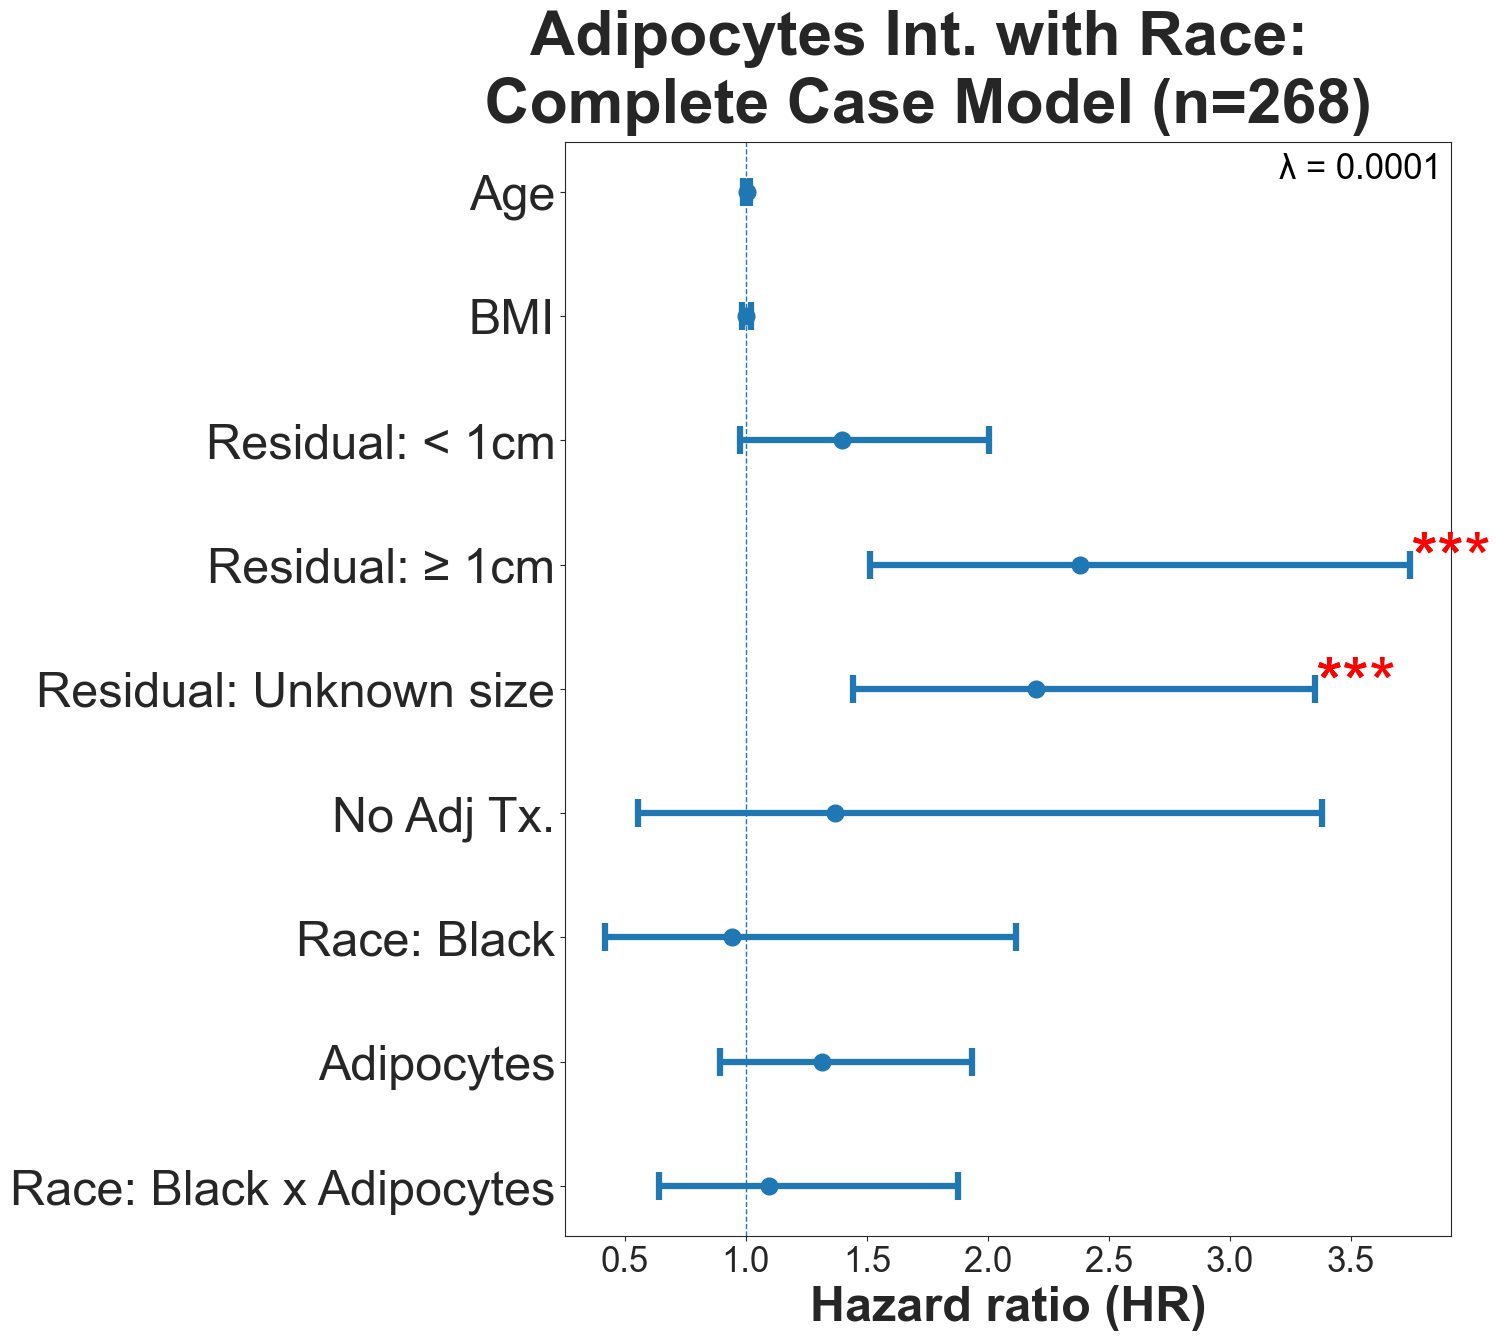

In [27]:
# ------------------------------------------------------------------
# 1. Pull the numbers we need, in a versiofn-agnostic way
# ------------------------------------------------------------------
summ = cph.summary.loc[desired_order].copy()

# locate the 95 % CI columns no matter what lifelines called them
ci_lower_col = [c for c in summ.columns if c.startswith("coef lower")][0]
ci_upper_col = [c for c in summ.columns if c.startswith("coef upper")][0]

summ["HR"] = np.exp(summ["coef"])
summ["lower95"] = np.exp(summ[ci_lower_col])
summ["upper95"] = np.exp(summ[ci_upper_col])

# ------------------------------------------------------------------
# 2. Plot on a *linear* x-axis
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(15, 1.5 * len(summ)))
ypos = np.arange(len(summ))

ax.errorbar(
    x=summ["HR"],
    y=ypos,
    xerr=[summ["HR"] - summ["lower95"], summ["upper95"] - summ["HR"]],
    fmt="o",
    capsize=10,
    linewidth=4.5,
    elinewidth=4.5,
    capthick=4.5,
    markersize=12,
)

ax.axvline(1, ls="--", lw=1)

# mark p < 0.05 covariates with a star
# mark p < 0.05 covariates with a BIG star
for i, p in enumerate(summ["p"]):
    if p < 0.05:
        ax.text(
            summ["upper95"].iloc[i] * 1.001,
            ypos[i],
            "*",
            va="center",
            fontsize=50,
            color="red",
        )
    if p < 0.005:
        ax.text(
            summ["upper95"].iloc[i] * 1.001,
            ypos[i],
            "**",
            va="center",
            fontsize=50,
            color="red",
        )
    if p < 0.0005:
        ax.text(
            summ["upper95"].iloc[i] * 1.001,
            ypos[i],
            "***",
            va="center",
            fontsize=50,
            color="red",
        )

penalizer_decimals = hp.count_decimal_places(best["penalizer"])
if penalizer_decimals > 4:  ## If there is more than 4, we'll limit it at 4.
    penal = f"{best['penalizer']:.4f}"
else:  # Otherwise the full decimals
    penal = f"{best['penalizer']}"

ax.text(
    0.99,
    0.99,  # (x, y) in axes coordinates (near bottom right)
    f"λ = {penal}",
    transform=ax.transAxes,
    ha="right",
    va="top",
    fontsize=25,
    color="black",
)

ax.set_yticks(ypos)
ax.set_yticklabels(summ.index, fontsize=35)
plt.xticks(fontsize=25)
ax.set_ylabel("", fontsize=35)
ax.set_xlabel("Hazard ratio (HR)", fontsize=35, fontweight="bold")
ax.set_title(title_for_plot, fontsize=45, fontweight="bold", y=1.01, x=0.4)
ax.invert_yaxis()  # top row at the top
plt.tight_layout()
plt.show()

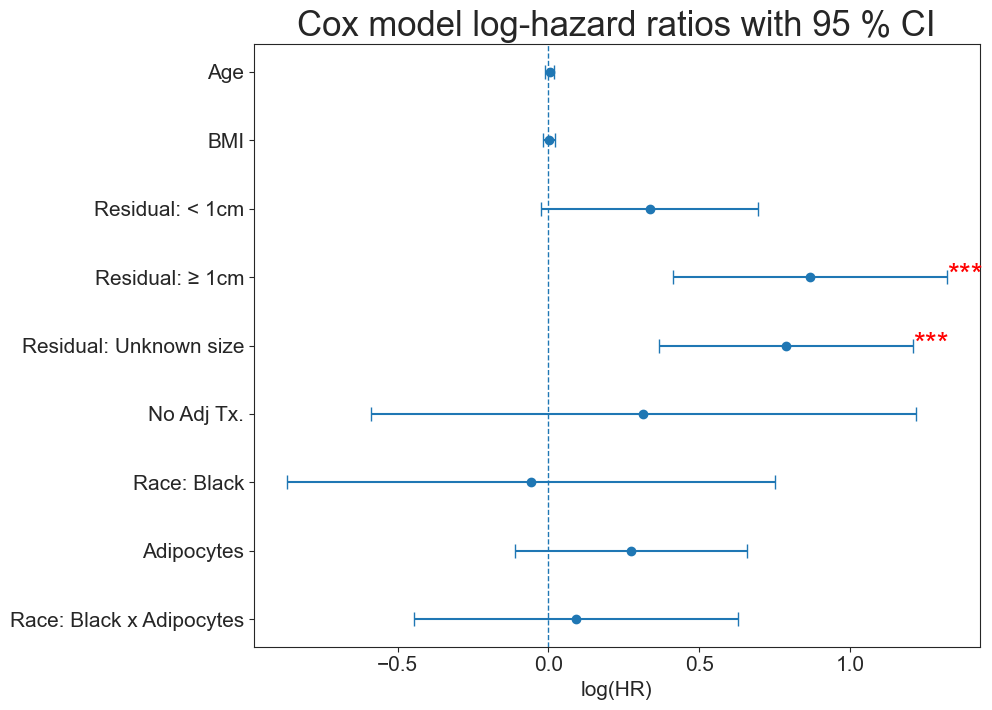

In [28]:
# ------------------------------------------------------------------
# 1. Pull the numbers we need, in a version-agnostic way
# ------------------------------------------------------------------
summ = cph.summary.loc[desired_order].copy()

# locate the 95 % CI columns no matter what lifelines called them
ci_lower_col = [c for c in summ.columns if c.startswith("coef lower")][0]
ci_upper_col = [c for c in summ.columns if c.startswith("coef upper")][0]

# log-scale columns (they’re already logs, but we rename for clarity)
summ["logHR"] = summ["coef"]
summ["lower95log"] = summ[ci_lower_col]
summ["upper95log"] = summ[ci_upper_col]

# ------------------------------------------------------------------
# 2. Plot on a *linear axis of log-HR*  (0 = HR 1)
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 0.8 * len(summ)))
ypos = np.arange(len(summ))

ax.errorbar(
    x=summ["logHR"],
    y=ypos,
    xerr=[summ["logHR"] - summ["lower95log"], summ["upper95log"] - summ["logHR"]],
    fmt="o",
    capsize=5,
    linewidth=1.5,
)

# reference line at β = 0  (i.e., HR = 1)
ax.axvline(0, ls="--", lw=1)

# mark p < 0.05 covariates with stars of increasing size / count
for i, p in enumerate(summ["p"]):
    if p < 0.05:
        ax.text(
            summ["upper95log"].iloc[i] + 0.0003,  # small shift right
            ypos[i],
            "*" if p >= 0.005 else "**" if p >= 0.0005 else "***",
            va="center",
            fontsize=22,
            color="red",
        )

# ------------------------------------------------------------------
# 3. Styling
# ------------------------------------------------------------------
ax.set_yticks(ypos)
ax.set_yticklabels(summ.index, fontsize=15)
ax.set_ylabel("")
ax.set_xlabel("log(HR)", fontsize=15)
ax.set_title("Cox model log-hazard ratios with 95 % CI", fontsize=25)
plt.xticks(fontsize=15)
ax.invert_yaxis()  # top row at the top
plt.tight_layout()
plt.show()

In [29]:
cph.check_assumptions(cox_df, p_value_threshold=0.05, show_plots=False)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 268 total observations, 62 right-censored observations>
         test_name = proportional_hazard_test

---
                            test_statistic    p  -log2(p)
Adipocytes            km              4.89 0.03      5.21
                      rank            3.03 0.08      3.61
Age                   km              0.29 0.59      0.77
                      rank            0.10 0.76      0.40
BMI                   km              0.15 0.70      0.51
                      rank            0.01 0.93      0.11
NoAdjTx               km              0.59 0.44      1.18
                      rank            1.67 0.20      2.34
Race_Black            km              3.24 0.07      3.80
                      rank            0.12 0.73      0.46
Race_Black:Adipocytes km              5.18 0.02      5.45
                      rank            0.44 0.51      0.98
ResUnkownSize         km              1.21 0.27      1.88
                      rank            1.61 0.20      2.29
Resless1cm            km              0.12 0.73      0.45
                      rank            0.00 0.95      0.07
Resmore1cm            km              0.14 0.71      0.50
                      rank            0.00 0.98      0.03



1. Variable 'Adipocytes' failed the non-proportional test: p-value is 0.0269.

   Advice 1: the functional form of the variable 'Adipocytes' might be incorrect. That is, there may
be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Adipocytes' using pd.cut, and then specify it in
`strata=['Adipocytes', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'Race_Black:Adipocytes' failed the non-proportional test: p-value is 0.0229.

   Advice 1: the functional form of the variable 'Race_Black:Adipocytes' might be incorrect. That
is, there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] be

[]

* **HR > 1** → Higher covariate value is associated with **shorter** survival.  
* **HR < 1** → Higher covariate value is associated with **longer** survival.